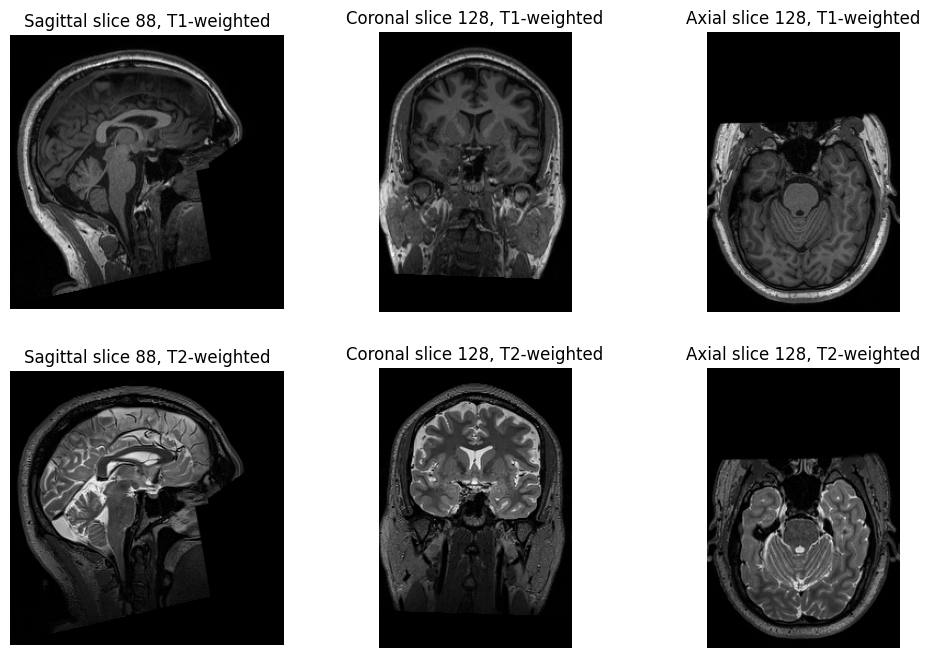

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pywt
from matplotlib.colors import CenteredNorm

t1_img = nib.load('ds001499/sub-CSI1/ses-16/anat/sub-CSI1_ses-16_run-01_T1w.nii.gz')
t2_img = nib.load('ds001499/sub-CSI1/ses-16/anat/sub-CSI1_ses-16_T2w.nii.gz')

t1 = t1_img.get_fdata()
t2 = t2_img.get_fdata()

# Middle indices
sag_idx = t1.shape[0] // 2
cor_idx = t1.shape[1] // 2
axi_idx = t1.shape[2] // 2

# Helper to extract and scale a slice
def get_slice(vol, axis, idx):
    if axis == 'Sagittal':
        slice = vol[idx, :, :]
    elif axis == 'Coronal':
        slice = vol[:, idx, :]
    elif axis == 'Axial':
        slice = vol[:, :, idx]
    return np.rot90(slice)
 
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Top row: T1
for ax, (axis, idx) in zip(axes[0], 
                           [('Sagittal', sag_idx),
                            ('Coronal', cor_idx),
                            ('Axial',   axi_idx)]):
    img = get_slice(t1, axis, idx)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{axis} slice {idx}, T1‑weighted')

# Bottom row: T2
for ax, (axis, idx) in zip(axes[1],
                           [('Sagittal', sag_idx),
                            ('Coronal', cor_idx),
                            ('Axial',   axi_idx)]):
    img = get_slice(t2, axis, idx)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{axis} slice {idx}, T2‑weighted')

plt.show()


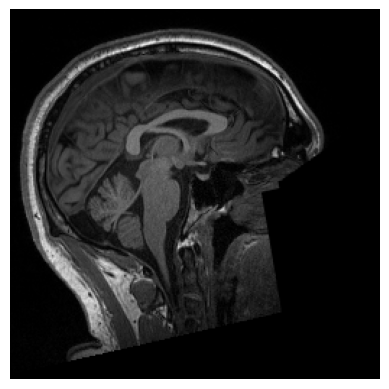

In [2]:
guide = get_slice(t1, 'Sagittal', sag_idx)
plt.imshow(guide, cmap='gray')
plt.axis('off')
plt.show()


## Helper Functions

### Normalize to [0, 1]

In [3]:
def normalize_01(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) if np.max(img) - np.min(img) > 0 else np.zeros_like(img)

arr = np.array([-2, -1, 0, 1, 2, 3])
normalized = normalize_01(arr)
print("arr:         ", arr)
print("normalized:  ", normalized)


arr:          [-2 -1  0  1  2  3]
normalized:   [0.  0.2 0.4 0.6 0.8 1. ]


### Normalize Centered

normalize to [-1, 1] where 1 is the absolute min or max

In [4]:
def normalize_centered(img):
    return img / np.max(np.abs(img)) if np.max(np.abs(img)) > 0 else np.zeros_like(img)

arr = np.array([-2, -1, 0, 1, 2, 3])
normalized = normalize_centered(arr)
print("arr:         ", arr)
print("normalized:  ", normalized)

arr:          [-2 -1  0  1  2  3]
normalized:   [-0.66666667 -0.33333333  0.          0.33333333  0.66666667  1.        ]


### Compress Array

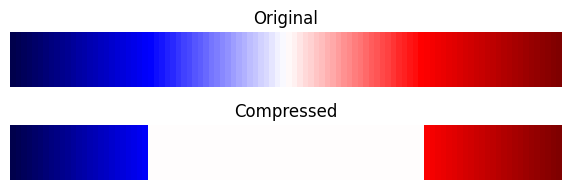

In [5]:
def compress_array(arr, s):
    abs_arr = np.abs(arr)
    thresh = np.percentile(abs_arr, s)
    mask = abs_arr >= thresh
    compressed_arr = arr * mask
    return compressed_arr

x = np.tile(np.linspace(-1, 1, 100), (10, 1))
y = compress_array(x, 50)

fig, axes = plt.subplots(2, 1, figsize=(10, 2))
axes[0].imshow(x, cmap='seismic', norm=CenteredNorm())
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(y, cmap='seismic', norm=CenteredNorm())
axes[1].set_title('Compressed')
axes[1].axis('off')

plt.tight_layout()

### Get MSE

In [6]:
def get_mse(pred, truth):
    return np.mean((pred - truth)**2)
get_mse(y, x)

np.float64(0.04249566370778493)

## Test Gratings

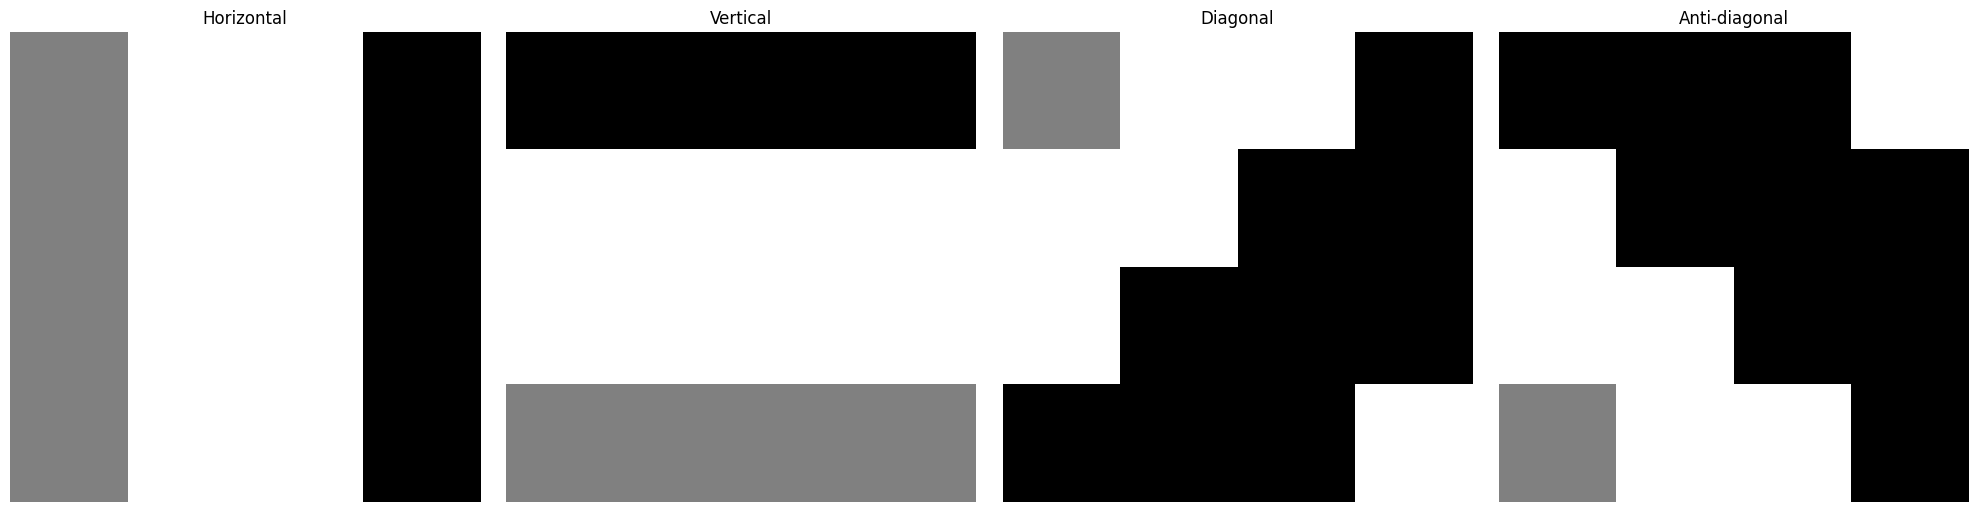

In [7]:
def generate_gratings(size=256, frequencies=[1], grating_type='sin', axes=None):
    # Angles for the two “base” gratings
    base_angles = {
        'Horizontal': 0,
        'Diagonal': np.pi/4,
    }

    # Generate the two base gratings
    x = np.arange(size)
    y = np.arange(size)
    X, Y = np.meshgrid(x, y)

    base_gratings = {}
    
    for name, theta in base_angles.items():
        coords = np.cos(theta) * X + np.sin(theta) * Y
        composite = np.zeros_like(coords, dtype=float)
        
        for f in frequencies:
            if grating_type == 'sin':
                composite += np.sin(2 * np.pi * f * coords / size)
            elif grating_type == 'square':
                composite += np.sign(np.sin(2 * np.pi * f * coords / size))
        
        base_gratings[name] = composite

    # rotate to get Vertical and Anti‑diagonal
    gratings = {
        'Horizontal': base_gratings['Horizontal'],
        'Vertical': np.rot90(base_gratings['Horizontal'], k=1),
        'Diagonal': base_gratings['Diagonal'],
        'Anti‑diagonal': np.rot90(base_gratings['Diagonal'], k=1),
    }

    if axes is not None:
        for ax, (title, img) in zip(axes, gratings.items()):
            ax.imshow(img, cmap='gray')
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    return gratings

#! slight offsets from the powers of 2 creates more interesting patterns, and exact powers create weird gradients
"""try 
127, 128, 
wavelet decomposition of 127 looks the same as 1 but shifted
actually wav dec of 126 looks like 2 shifted, 
255, 256
1 and 255 look the same but inverted
"""
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
gratings = generate_gratings(size=4, frequencies=[1], grating_type='square', axes=axes)


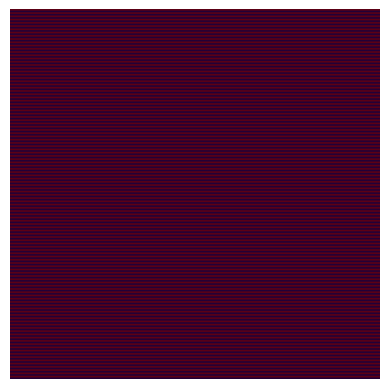

(np.float64(1.0), np.float64(1.0))

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def generate_grating(frequencies, grating_type='sine', size=512, direction='horizontal', phase_shift=0):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    X, Y = np.meshgrid(x, y)
    grating = np.zeros((size, size))

    if direction == 'horizontal':
        grating_direction = X
    elif direction == 'vertical':
        grating_direction = Y
    elif direction == 'diagonal':
        grating_direction = X + Y
    elif direction == 'anti-diagonal':
        grating_direction = X - Y
    
    # Add sinusoidal components for each frequency
    for freq in frequencies:
        sin_value = np.sin((freq) * grating_direction + phase_shift)
        if grating_type == 'sine':
            grating += sin_value
        elif grating_type == 'square':
            grating += np.where(np.sign(sin_value) == 0, 1, np.sign(sin_value)) # avoid zero values

    return grating

frequencies = [256]
grating_type = 'square' # 'sine' or 'square'
size = 512
direction = 'vertical'# ['horizontal', 'vertical', 'diagonal', 'anti-diagonal']
phase_shift = 0

grating = generate_grating(frequencies, grating_type, size, direction, phase_shift)

plt.imshow(grating, cmap='seismic', norm=CenteredNorm())
plt.axis('off')
plt.show()
grating[0,127], grating[0,128]

## Plot Wavelet Function

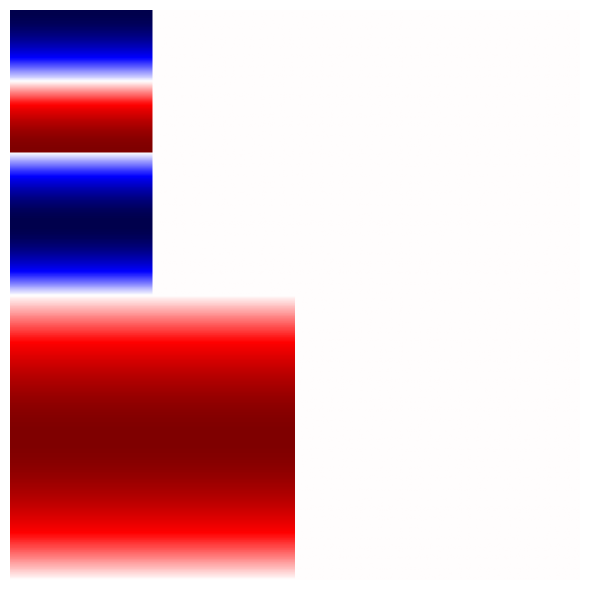

In [ ]:
def plot_wavelet_levels(img, wavelet='haar', level=None, cmap='gray', norm=CenteredNorm(), ax=None, normalize_indep=True, verbose=False):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)

    if normalize_indep:
        norm_coeffs = [normalize_centered(coeffs[0])]
        for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            norm_cH = normalize_centered(cH)
            norm_cV = normalize_centered(cV)
            norm_cD = normalize_centered(cD)
            norm_coeffs.append((norm_cH, norm_cV, norm_cD))
        arr, slices = pywt.coeffs_to_array(norm_coeffs)
    else:
        arr, slices = pywt.coeffs_to_array(coeffs)
        
    if verbose:
        print("Approximation coefficients (Level 0):")
        print(f"  min: {coeffs[0].min()}, max: {coeffs[0].max()}")
        print(f"Detail coefficients (Level {i}):")
        print(f"  Horizontal (cH): min = {cH.min()}, max = {cH.max()}")
        print(f"  Vertical   (cV): min = {cV.min()}, max = {cV.max()}")
        print(f"  Diagonal   (cD): min = {cD.min()}, max = {cD.max()}")

    if ax:
        ax.imshow(arr, cmap=cmap, norm=norm)
        ax.axis('off')

    return arr

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
coeffs = plot_wavelet_levels(grating, wavelet='haar', level=2, cmap='seismic', ax=ax, normalize_indep=True)
fig.tight_layout()

## Compress in the FFT Domain

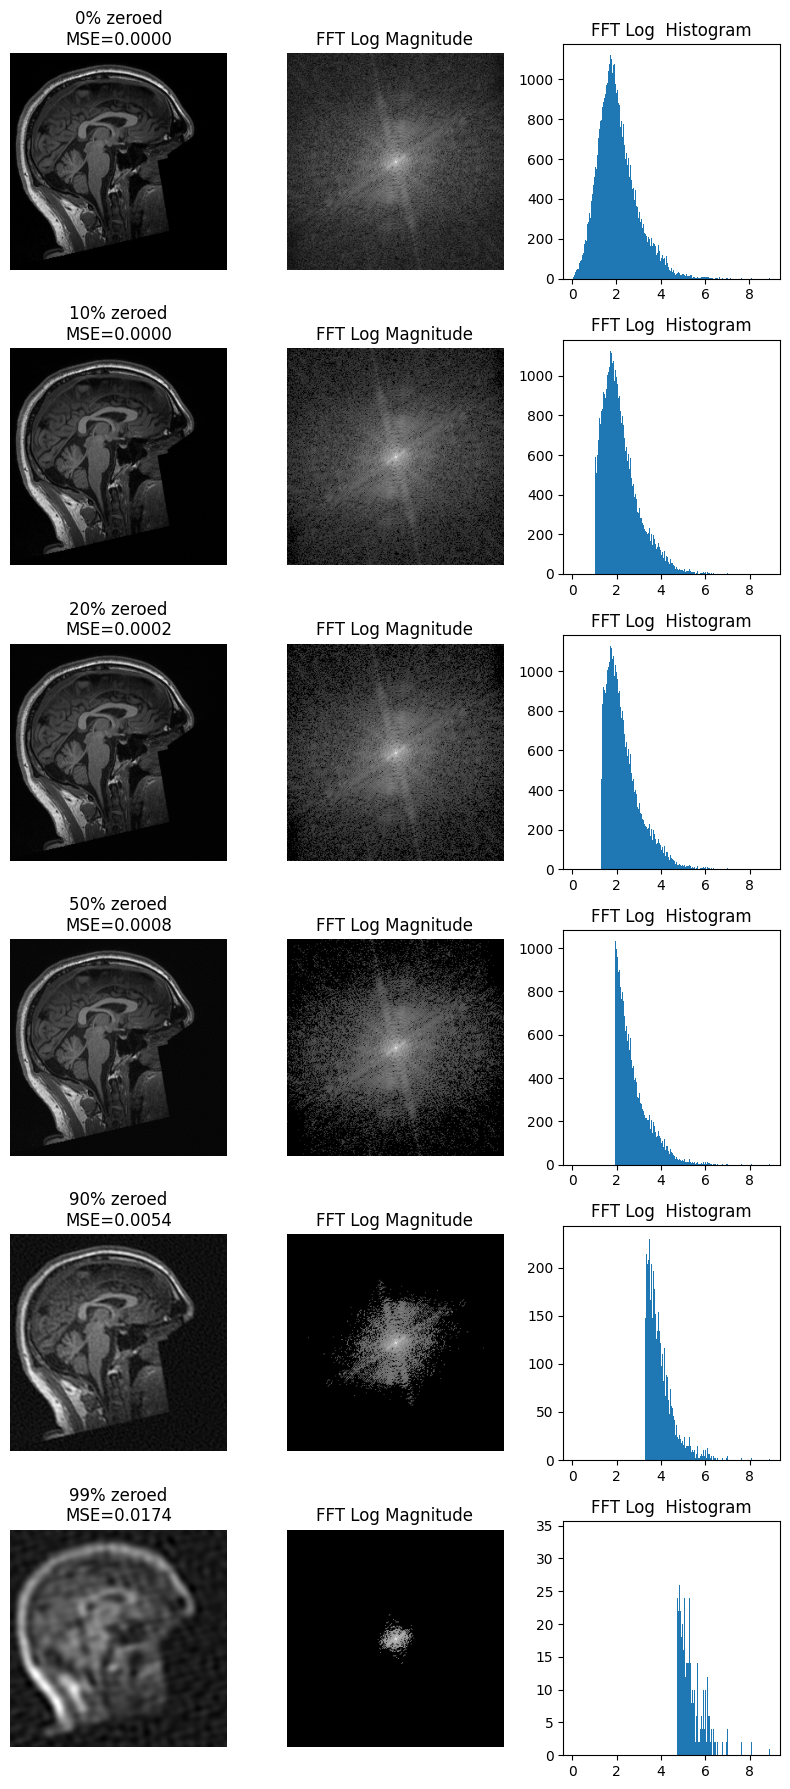

In [10]:
def compress_wav(img, s, axes=None, axes_row=0):
    normalized_img = normalize_01(img)
    FFT_img = np.fft.fftshift(np.fft.fft2(normalized_img))
    
    F_compressed = compress_array(FFT_img, s)
    
    reconstructed = np.real(np.fft.ifft2(np.fft.ifftshift(F_compressed)))
    normalized_reconstructed = normalize_01(reconstructed)
    
    F_mag = np.abs(F_compressed)
    F_log_mag = np.log1p(F_mag)
    
    mse = get_mse(normalized_reconstructed, normalized_img)
    
    if axes is not None:
        # Handle 1D axes case
        def get_ax(row, col):
            if axes.ndim == 1:
                return axes[col]  # Ignore 'row' for 1D case
            return axes[row, col]

        # Compressed image
        get_ax(axes_row, 0).imshow(normalized_reconstructed, cmap='gray')
        get_ax(axes_row, 0).set_title(f'{s}% zeroed\nMSE={mse:.4f}')
        get_ax(axes_row, 0).axis('off')

        # FFT log-magnitude image
        get_ax(axes_row, 1).imshow(F_log_mag, cmap='gray')
        get_ax(axes_row, 1).set_title('FFT Log Magnitude')
        get_ax(axes_row, 1).axis('off')

        # Histogram of FFT log-magnitude
        hist, bin_edges = np.histogram(F_log_mag.ravel(), bins=300)

        # Exclude the first bin if nonzero compression
        if s > 0:
            hist = hist[1:]
            bin_edges = bin_edges[1:]

        get_ax(axes_row, 2).bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        get_ax(axes_row, 2).set_title('FFT Log  Histogram')

    return reconstructed, F_log_mag, mse

# Set your compression levels
s_vals = [0, 10, 20, 50, 90, 99]

fig, axes = plt.subplots(len(s_vals), 3, figsize=(8, 18))
for i, s in enumerate(s_vals):
    rec, F_log_mag, mse = compress_wav(guide, s, axes=axes, axes_row=i)
fig.tight_layout()

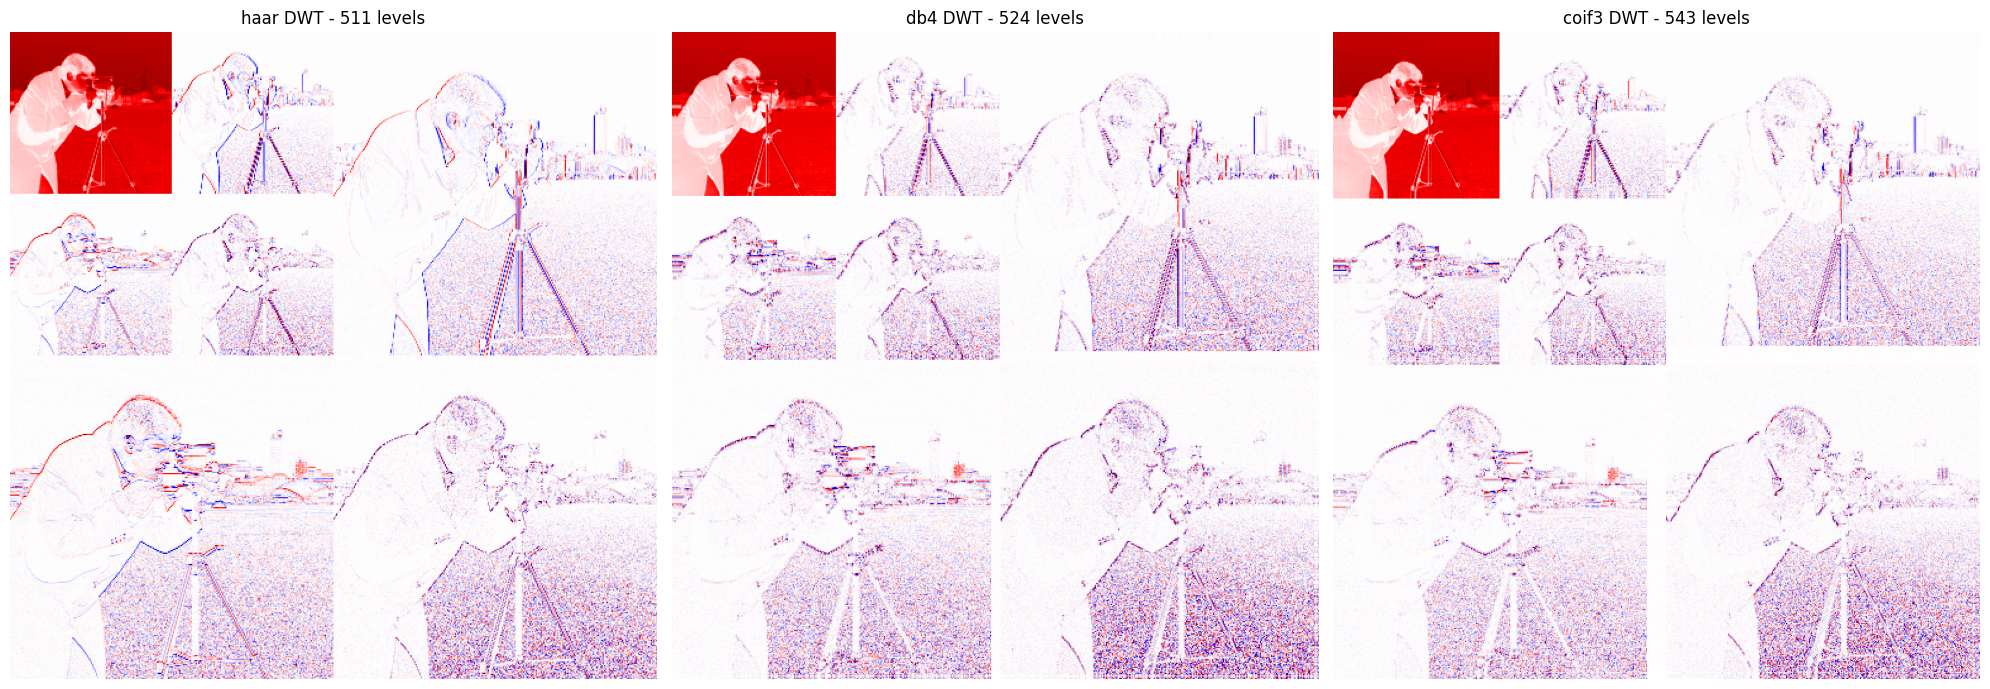

In [11]:
cameraman = pywt.data.camera()

wavelets = ['haar', 'db4', 'coif3']
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax, wavelet in zip(axes, wavelets):
    coeffs = plot_wavelet_levels(cameraman, wavelet=wavelet, level=2, cmap='seismic', ax=ax, normalize_indep=True)
    ax.set_title(f"{wavelet} DWT - {len(coeffs)-1} level{'s' if len(coeffs)-1 > 1 else ''}")
fig.tight_layout()

## Standard Basis Element

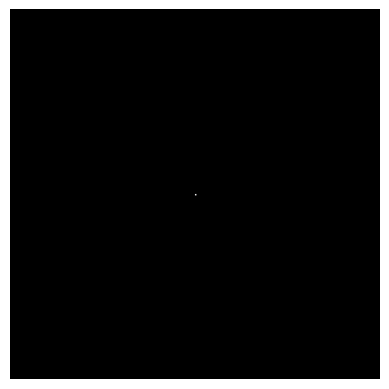

In [12]:
size = 256
imp_pos = (size // 2, size // 2)

# Create standard basis image (delta function)
imp_img = np.zeros((size, size))
imp_img[imp_pos] = 1.0

plt.imshow(imp_img, cmap='gray')
plt.axis('off')
plt.show()

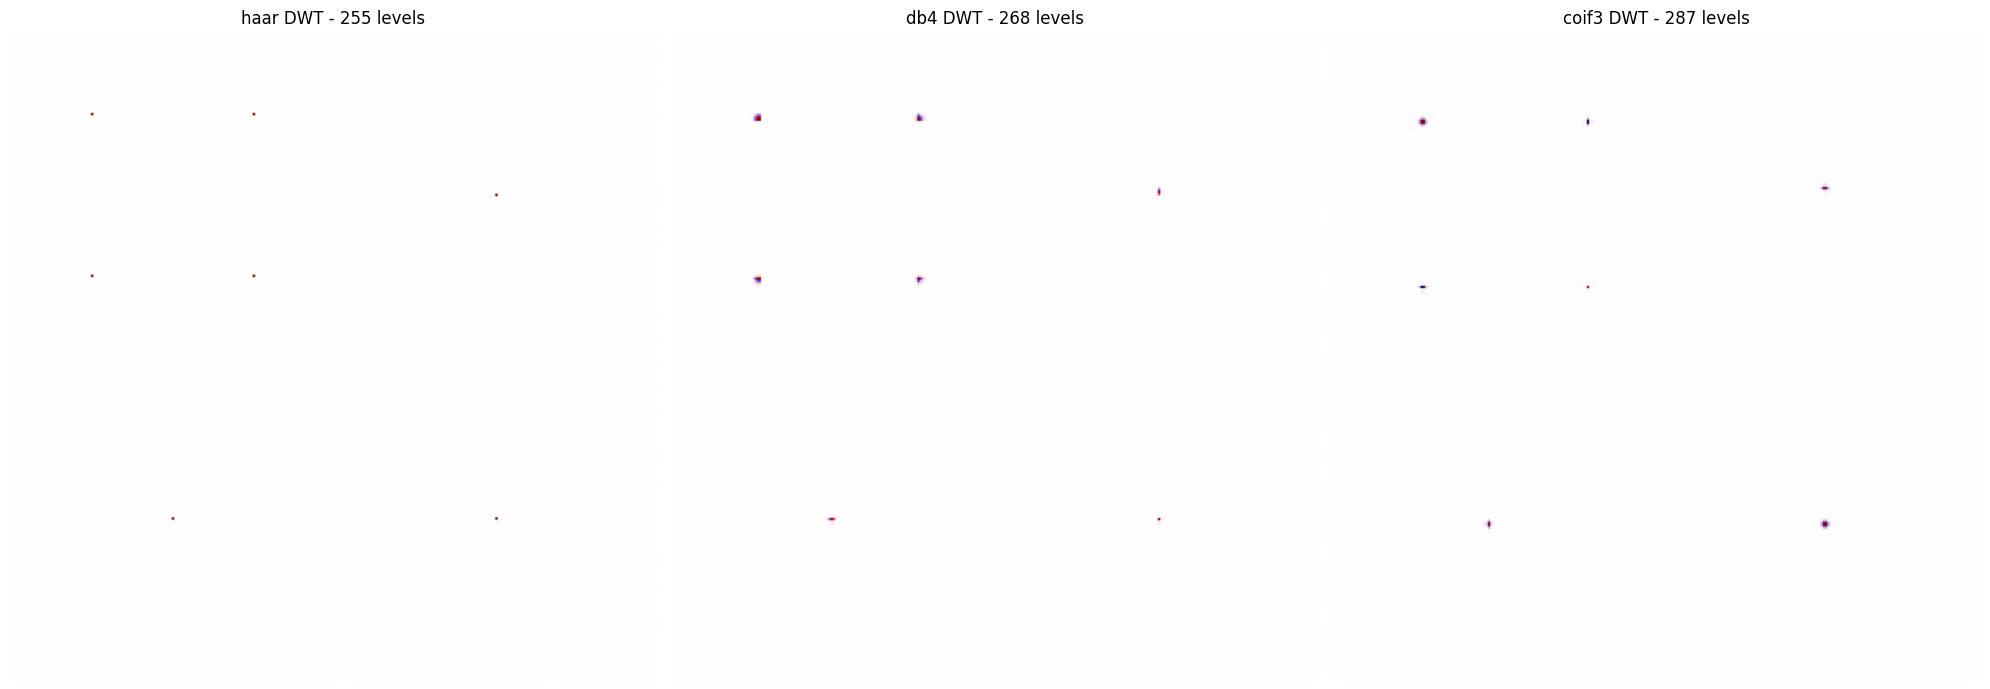

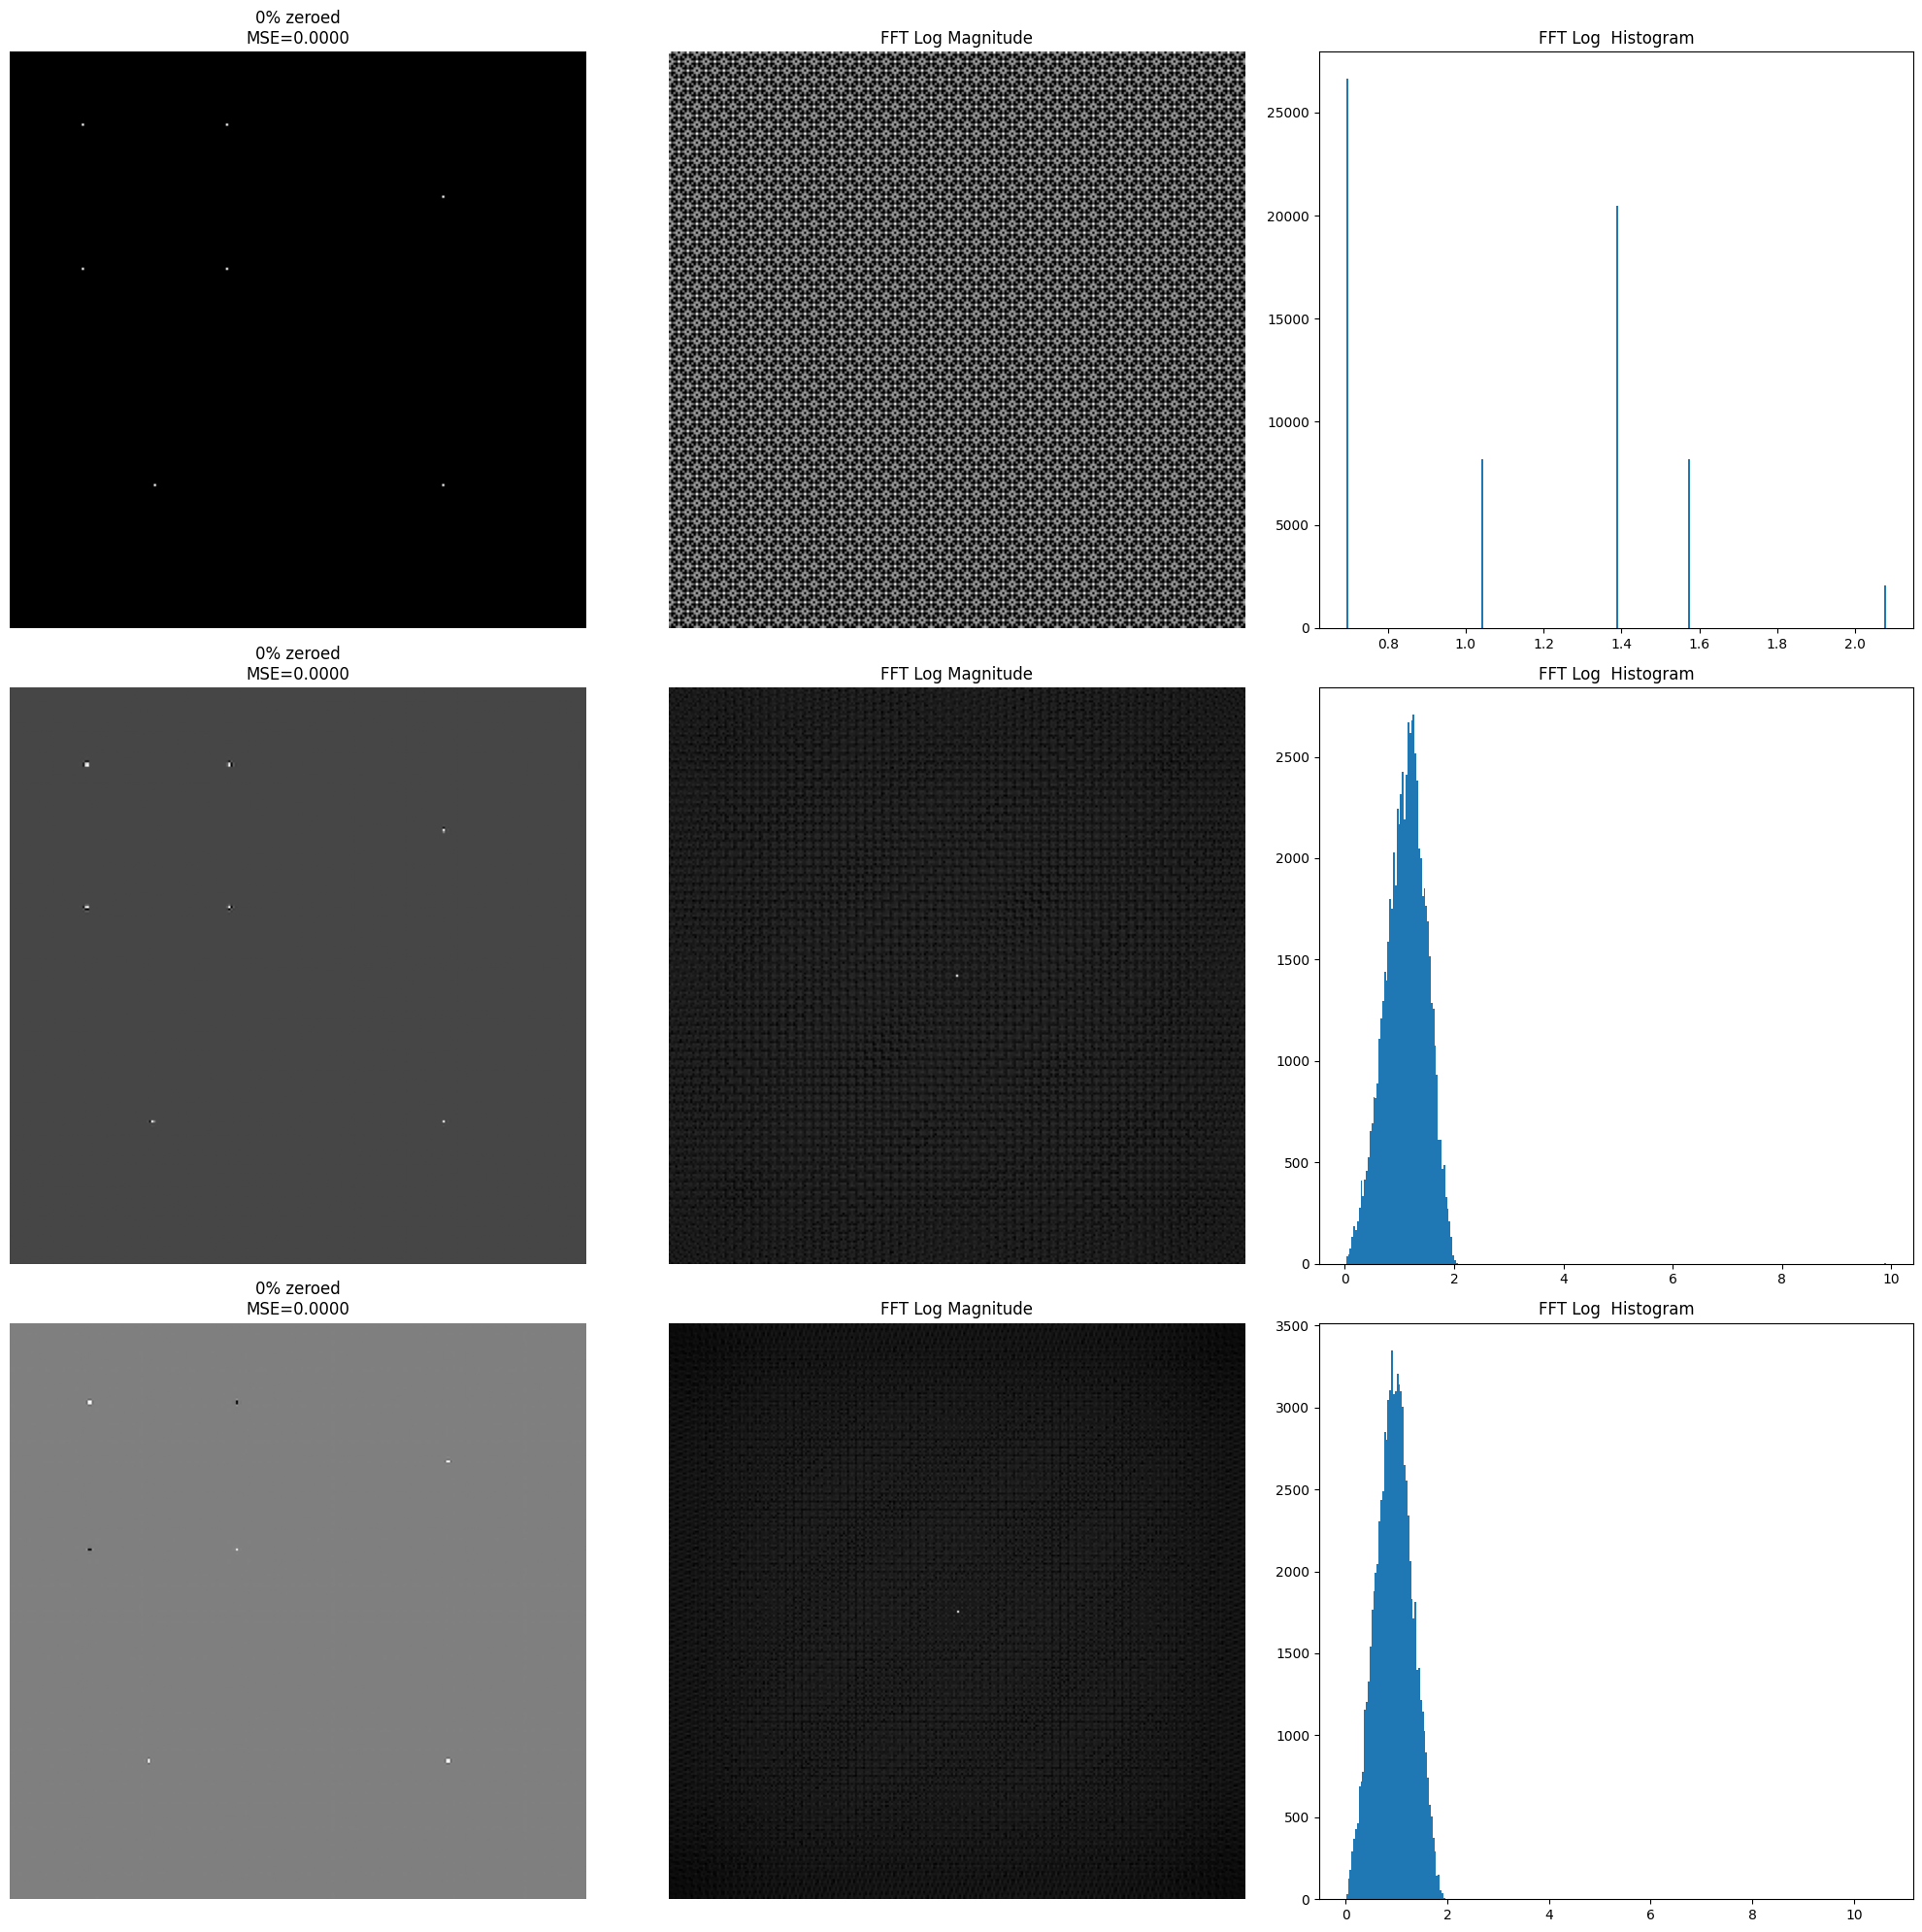

In [13]:
wavelets = ['haar', 'db4', 'coif3']
fig1, axes1 = plt.subplots(1, 3, figsize=(20, 8))
fig2, axes2 = plt.subplots(3, 3, figsize=(20, 20))
for i, (ax1, wavelet) in enumerate(zip(axes1, wavelets)):
    coeffs = plot_wavelet_levels(imp_img, wavelet=wavelet, level=2, cmap='seismic', ax=ax1, normalize_indep=True)
    ax1.set_title(f"{wavelet} DWT - {len(coeffs)-1} level{'s' if len(coeffs)-1 > 1 else ''}")
    compress_wav(coeffs, 0, axes=axes2, axes_row=i)
fig1.tight_layout()
fig2.tight_layout()

## Canonical Spatial Representations

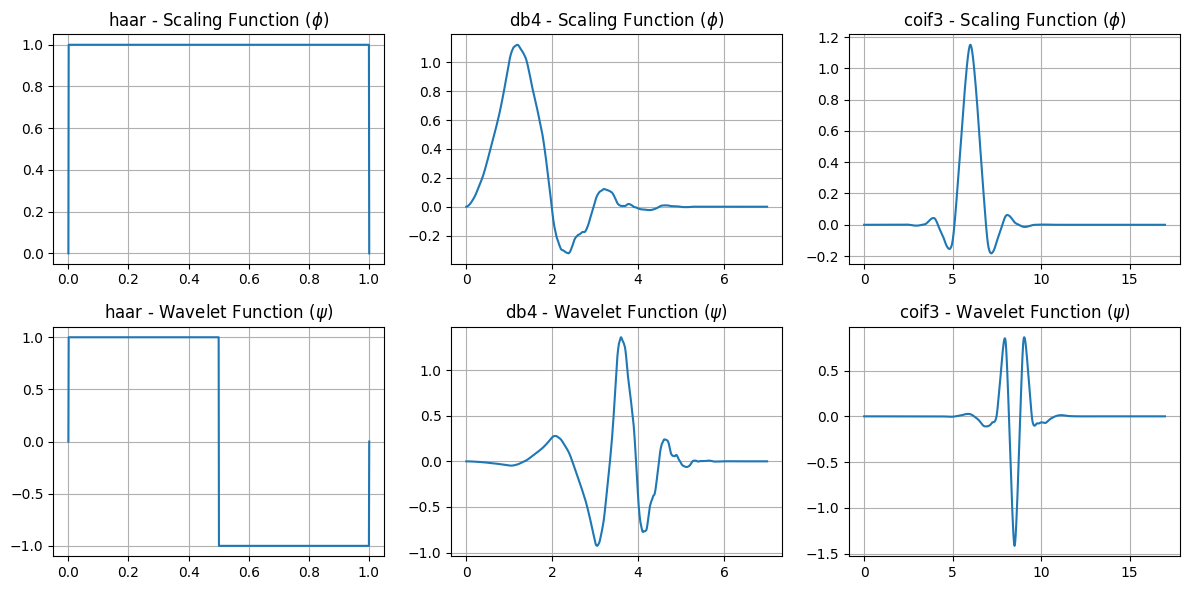

In [14]:
wavelet_names = ['haar', 'db4', 'coif3']

# Create the plots
plt.figure(figsize=(12, 6))
for i, name in enumerate(wavelet_names):
    wavelet = pywt.Wavelet(name)
    phi, psi, x = wavelet.wavefun(level=10)
    plt.subplot(2, len(wavelet_names), i + 1)
    plt.plot(x, phi)
    plt.title(f'{name} - Scaling Function ($\\phi$)')
    plt.grid(True)
    
    plt.subplot(2, len(wavelet_names), i + 1 + len(wavelet_names))
    plt.plot(x, psi)
    plt.title(f'{name} - Wavelet Function ($\\psi$)')
    plt.grid(True)

plt.tight_layout()
plt.show()


## Wavelet Decomposition of Guide

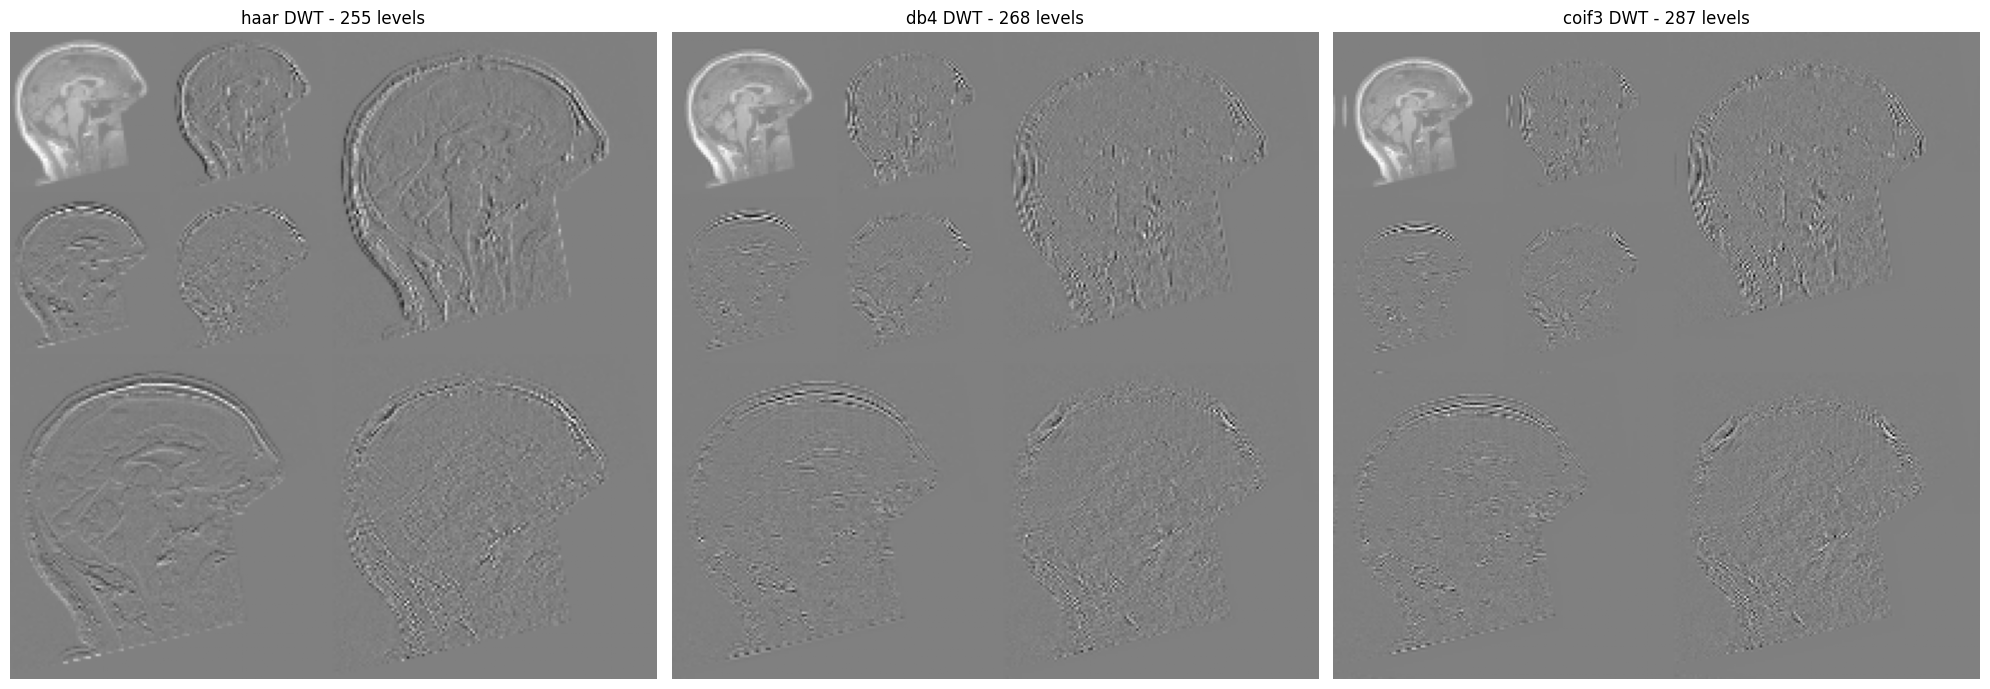

In [15]:
wavelets = ['haar', 'db4', 'coif3']
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax, wavelet in zip(axes, wavelets):
    coeffs = plot_wavelet_levels(guide, wavelet=wavelet, level=2, ax=ax)
    ax.set_title(f"{wavelet} DWT - {len(coeffs)-1} level{'s' if len(coeffs)-1 > 1 else ''}")
fig.tight_layout()

## Wavelet Compression

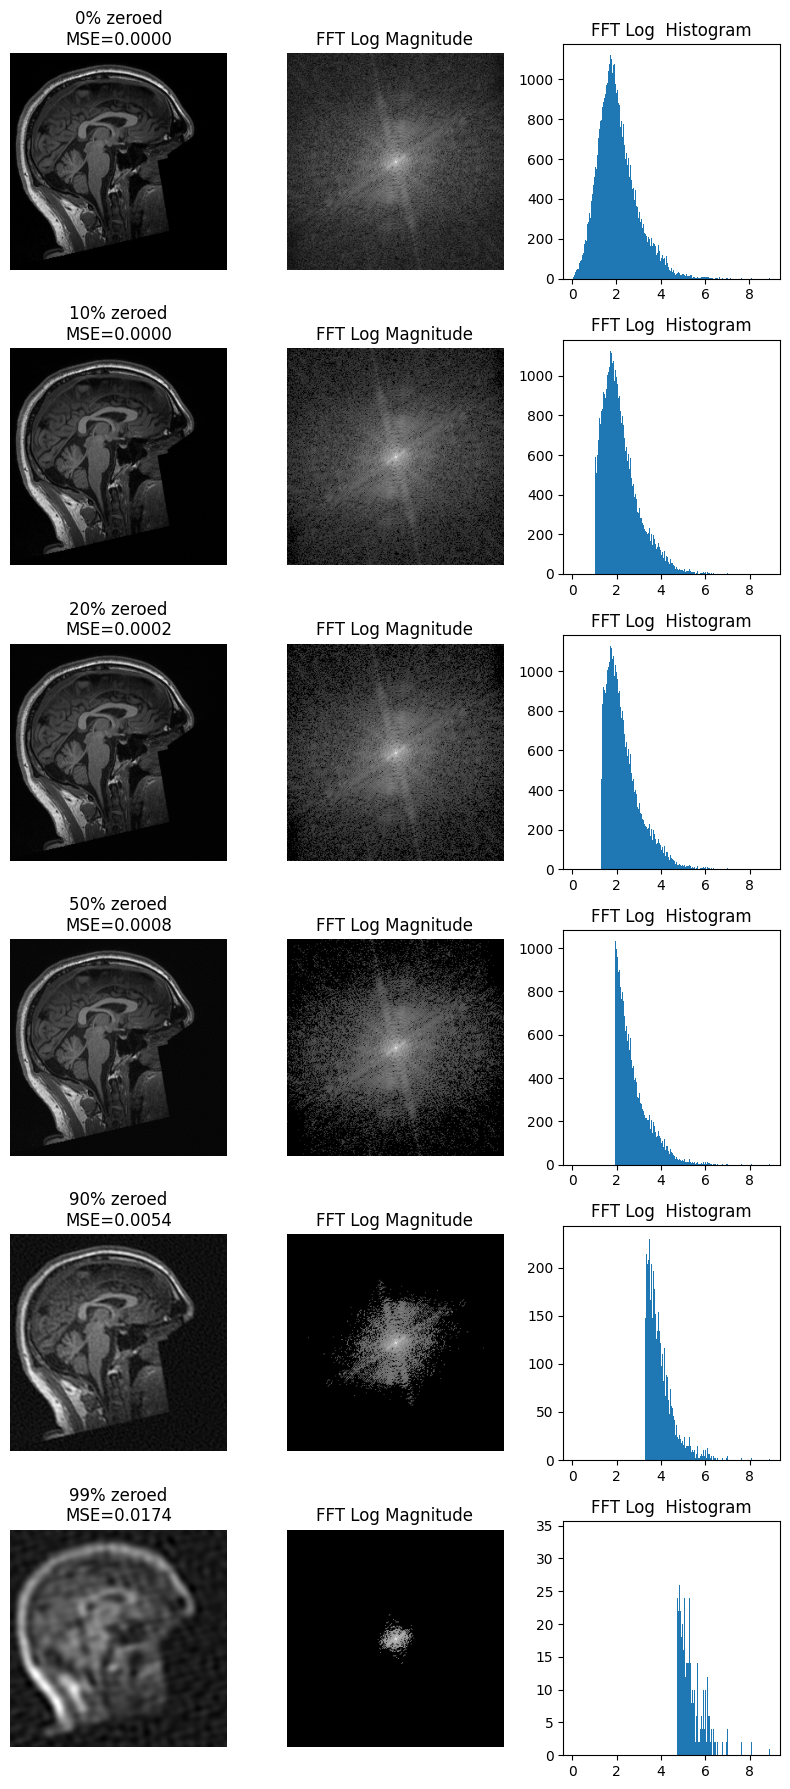

In [16]:
def plot_wavelet_levels(img, wavelet='haar', level=None, cmap='gray', norm=CenteredNorm(), ax=None, normalize_indep=True, verbose=False):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)

    if normalize_indep:
        norm_coeffs = [normalize_centered(coeffs[0])]
        for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            norm_cH = normalize_centered(cH)
            norm_cV = normalize_centered(cV)
            norm_cD = normalize_centered(cD)
            norm_coeffs.append((norm_cH, norm_cV, norm_cD))
        arr, slices = pywt.coeffs_to_array(norm_coeffs)
    else:
        arr, slices = pywt.coeffs_to_array(coeffs)
        
    if verbose:
        print("Approximation coefficients (Level 0):")
        print(f"  min: {coeffs[0].min()}, max: {coeffs[0].max()}")
        print(f"Detail coefficients (Level {i}):")
        print(f"  Horizontal (cH): min = {cH.min()}, max = {cH.max()}")
        print(f"  Vertical   (cV): min = {cV.min()}, max = {cV.max()}")
        print(f"  Diagonal   (cD): min = {cD.min()}, max = {cD.max()}")

    if ax:
        ax.imshow(arr, cmap=cmap, norm=norm)
        ax.axis('off')

    return arr

def compress_wav(img, s, axes=None, axes_row=0):
    normalized_img = normalize_01(img)
    FFT_img = np.fft.fftshift(np.fft.fft2(normalized_img))
    
    F_compressed = compress_array(FFT_img, s)
    
    reconstructed = np.real(np.fft.ifft2(np.fft.ifftshift(F_compressed)))
    normalized_reconstructed = normalize_01(reconstructed)
    
    F_mag = np.abs(F_compressed)
    F_log_mag = np.log1p(F_mag)
    
    mse = get_mse(normalized_reconstructed, normalized_img)
    
    if axes is not None:
        # Handle 1D axes case
        def get_ax(row, col):
            if axes.ndim == 1:
                return axes[col]  # Ignore 'row' for 1D case
            return axes[row, col]

        # Compressed image
        get_ax(axes_row, 0).imshow(normalized_reconstructed, cmap='gray')
        get_ax(axes_row, 0).set_title(f'{s}% zeroed\nMSE={mse:.4f}')
        get_ax(axes_row, 0).axis('off')

        # FFT log-magnitude image
        get_ax(axes_row, 1).imshow(F_log_mag, cmap='gray')
        get_ax(axes_row, 1).set_title('FFT Log Magnitude')
        get_ax(axes_row, 1).axis('off')

        # Histogram of FFT log-magnitude
        hist, bin_edges = np.histogram(F_log_mag.ravel(), bins=300)

        # Exclude the first bin if nonzero compression
        if s > 0:
            hist = hist[1:]
            bin_edges = bin_edges[1:]

        get_ax(axes_row, 2).bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        get_ax(axes_row, 2).set_title('FFT Log  Histogram')

    return reconstructed, F_log_mag, mse

# Set your compression levels
s_vals = [0, 10, 20, 50, 90, 99]

fig, axes = plt.subplots(len(s_vals), 3, figsize=(8, 18))
for i, s in enumerate(s_vals):
    rec, F_log_mag, mse = compress_wav(guide, s, axes=axes, axes_row=i)
fig.tight_layout()